In [383]:
%matplotlib inline
%load_ext autoreload
import re
import os
import numpy as np
import pandas as pd
from requests import get
from tabulate import tabulate
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
#%aimport utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Table of content

1. [Data Acquisition](#data_acqui)
    * [Loading](#loading)
    * [Cleaning](#cleaning)
        * [Transition](#c_trans)
        * [Demographic](#c_demo)
        * [Product](#c_prod)
    * [Saving files](#saving)
2. [Exploration](#exploration)
    * [Getting sense of the data](#sense)
        * [Feature presentation](#feat_pres)
            * [Transition](#fp_tran)
            * [Demographic](#fp_demo)
            * [Product](#fp_prod)
        * [Feature range](#ft_range)
            * [Transition](#ft_tran)
            * [Demographic](#ft_demo)
            * [Product](#ft_prod)
        * [Distributions](#distributions)
            * [Transition](#d_tran)
            * [Demographic](#d_demo)
            * [Product](#d_prod)
        * [Outliers analysis](#outliers)
3. [Exploitation (work in progress...)](#explo)

<a id=data_acqui></a>
# 1. Data Acquisition

<a id=loading></a>
## Loading

In [384]:
dfList = []
for r, d, f in os.walk('../data/dunnhumby - The Complete Journey CSV/'):
    for file in f:
        if '.csv' in file:
            print(file)
            dfList.append(pd.read_csv(os.path.join(r, file)))

campaign_desc.csv
campaign_table.csv
causal_data.csv
coupon.csv
coupon_redempt.csv
hh_demographic.csv
product.csv
transaction_data.csv


In [390]:
hh_demographic_df = dfList[5].copy()
product_df = dfList[6].copy()
transaction_data_df = dfList[7].copy()


In [391]:
# This table contains all products purchased by households within this study. Each line found in
# this table is essentially the same line that would be found on a store receipt.
transaction_data_df.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [392]:
# This table contains demographic information for a portion of households. Due to nature of the
# data, the demographic information is not available for all households.
hh_demographic_df.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [393]:
# This table contains information on each product sold such as type of product, national or
# private label and a brand identifier.
product_df.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


<a id=cleaning></a>
## Cleaning

<a id=c_trans></a>
### Transactions

In [394]:
transaction_data_df.dtypes

household_key          int64
BASKET_ID              int64
DAY                    int64
PRODUCT_ID             int64
QUANTITY               int64
SALES_VALUE          float64
STORE_ID               int64
RETAIL_DISC          float64
TRANS_TIME             int64
WEEK_NO                int64
COUPON_DISC          float64
COUPON_MATCH_DISC    float64
dtype: object

In [395]:
# Transaction df is clean
print("Is there any NaN in transaction table: %s" %transaction_data_df.isna().any().any())

Is there any NaN in transaction table: False


In [396]:
# Lowercase all column names
transaction_data_df.columns = map(str.lower, transaction_data_df.columns)

In [397]:
# Set timestamp to the trans_time feature
transaction_data_df.trans_time = transaction_data_df.trans_time.astype(str)
trans_time_tmp = pd.to_datetime(transaction_data_df\
                                .trans_time.apply(lambda val: (4 - len(val)) * '0' + val if (len(val) < 4) else val), format='%H%M')
transaction_data_df.trans_time = trans_time_tmp.apply(lambda x: x.time())


<a id=c_demo></a>
## Demographic

In [398]:
# Every feature but house_hold key is an object. The object type is not helpful. We
# must cast it to categorical data.
hh_demographic_df.dtypes

AGE_DESC               object
MARITAL_STATUS_CODE    object
INCOME_DESC            object
HOMEOWNER_DESC         object
HH_COMP_DESC           object
HOUSEHOLD_SIZE_DESC    object
KID_CATEGORY_DESC      object
household_key           int64
dtype: object

#### INCOME_DESC

In [399]:
# Cast and set order
hh_demographic_df['INCOME_DESC'] = hh_demographic_df['INCOME_DESC'].astype('category')
hh_demographic_df.INCOME_DESC = hh_demographic_df.INCOME_DESC.cat.\
                                reorder_categories(['Under 15K', '15-24K','25-34K', '35-49K', '50-74K','75-99K', '100-124K','125-149K','150-174K', '175-199K', '200-249K', '250K+'], ordered=True)

#### KID_CATEGORY_DESC 

In [400]:
# Cast and set order
hh_demographic_df.KID_CATEGORY_DESC = hh_demographic_df.KID_CATEGORY_DESC.astype('category')
hh_demographic_df.KID_CATEGORY_DESC.cat.reorder_categories(['1', '2', '3+', 'None/Unknown']\
                                                          , ordered=True, inplace=True)

#### HOMEOWNER_DESC

In [401]:
# Casting
hh_demographic_df.HOMEOWNER_DESC = hh_demographic_df.HOMEOWNER_DESC.astype('category')

#### HH_COMP_DESC

In [402]:
# Casting
hh_demographic_df.HH_COMP_DESC = hh_demographic_df.HH_COMP_DESC.astype('category')

#### AGE_DESC

In [403]:
# Cast and set order
hh_demographic_df.AGE_DESC = hh_demographic_df.AGE_DESC.astype('category')
hh_demographic_df.AGE_DESC.cat\
                    .reorder_categories(['19-24', '25-34', '35-44', '45-54', '55-64', '65+'], ordered=True, inplace=True)

#### HOUSEHOLD_SIZE_DESC

In [404]:
# Cast and set order
hh_demographic_df.HOUSEHOLD_SIZE_DESC = hh_demographic_df.HOUSEHOLD_SIZE_DESC.astype('category')
hh_demographic_df.HOUSEHOLD_SIZE_DESC.cat.reorder_categories(\
                        ['1', '2', '3', '4', '5+'], ordered=True, inplace=True)

#### MARITAL_STATUS_CODE

In [405]:
# Cast
hh_demographic_df.MARITAL_STATUS_CODE = hh_demographic_df.MARITAL_STATUS_CODE.astype('category')

### Checking missing values

In [406]:
# Demographic df is clean
print("Is there any NaN in transaction table: %s" %hh_demographic_df.isna().any().any())

Is there any NaN in transaction table: False


In [407]:
# Lowercase all column names
hh_demographic_df.columns = map(str.lower, hh_demographic_df.columns)

<a id=c_prod></a>
## Product

In [408]:
product_df.dtypes

PRODUCT_ID               int64
MANUFACTURER             int64
DEPARTMENT              object
BRAND                   object
COMMODITY_DESC          object
SUB_COMMODITY_DESC      object
CURR_SIZE_OF_PRODUCT    object
dtype: object

In [409]:
# Casting
product_df.DEPARTMENT = product_df.DEPARTMENT.astype('category')
product_df.BRAND = product_df.BRAND.astype('category')
product_df.COMMODITY_DESC = product_df.COMMODITY_DESC.astype('category')
product_df.SUB_COMMODITY_DESC = product_df.SUB_COMMODITY_DESC.astype('category')
product_df.CURR_SIZE_OF_PRODUCT = product_df.CURR_SIZE_OF_PRODUCT.astype('category')

In [410]:
# Lowercase all column names
product_df.columns = map(str.lower, product_df.columns)

In [411]:
# Product df is clean
print("Is there any NaN in transaction table: %s" %product_df.isna().any().any())

Is there any NaN in transaction table: False


<a id=saving></a>
## Saving files

In [412]:
product_df.set_index('product_id', inplace=True)

In [413]:
hh_demographic_df.set_index('household_key', inplace=True)

In [414]:
# We assume here that a transaction is uniquely identifiied by the set of 3 features:
# household_keay | BASKET_ID | PRODUCT_ID
transaction_data_df.set_index(['household_key', 'basket_id', 'product_id'], inplace=True)

In [415]:
# This is verified by the following test
print("Transaction dataframe index is unique: %s" % transaction_data_df.index.is_unique)

Transaction dataframe index is unique: True


In [420]:
product_df.to_pickle('../data/preprocessed_data/product.pkl')
transaction_data_df.to_pickle('../data/preprocessed_data/transaction.pkl')
hh_demographic_df.to_pickle('../data/preprocessed_data/demographic.pkl')

<a id=exploration></a>
# 2. Exploration

In [421]:
# Loading clean data
product_df = pd.read_pickle('../data/preprocessed_data/product.pkl')
transaction_df = pd.read_pickle('../data/preprocessed_data/transaction.pkl')
transaction_df.trans_time = pd.to_datetime(transaction_df.trans_time, format='%H:%M:%S').dt.time
demographic_df = pd.read_pickle('../data/preprocessed_data/demographic.pkl')

<a id=sense></a>
## Getting a sense of the data

<a id=feat_pres></a>
### Features presentation

For some features whose sense are not easy to grasp, we give some insights

In [422]:
def print_index_columns(df):
    '''
        Present the index and the features of the DataFrame
    '''
    
    print("index: ", " | ".join(list(df.index.names)))
    print("features: ")
    for idx, col in enumerate(df.columns.tolist()):
        print("\t %i) %s" % (idx,col))

<a id=fp_tran></a>
#### Transaction

In [423]:
print_index_columns(transaction_df)

index:  household_key | basket_id | product_id
features: 
	 0) day
	 1) quantity
	 2) sales_value
	 3) store_id
	 4) retail_disc
	 5) trans_time
	 6) week_no
	 7) coupon_disc
	 8) coupon_match_disc


*day:*
> from 1 to 711, corresponds to the daytime in the *two year long* study

*sales_value:*

> amount of dollars retailer receives from sale. It's not the price paid by the customer. If a customer use a coupon, he will pay less and the retailer will be reinboursed by the manufacturer.

*retail_disc:*
> Discount applied due to retailer's loyalty card program

*coupon_disc:*
> Discount applied due to manufacturer coupon.

<a id=fp_demo></a>
#### Demographic

In [424]:
print_index_columns(demographic_df)

index:  household_key
features: 
	 0) age_desc
	 1) marital_status_code
	 2) income_desc
	 3) homeowner_desc
	 4) hh_comp_desc
	 5) household_size_desc
	 6) kid_category_desc


*hh_comp_desc:*
> Household composition

*kid_category_desc:*
> Number of children present in the household. If 3 or more children is given by '3+'

<a id=fp_prod></a>
#### Product

In [425]:
print_index_columns(product_df)

index:  product_id
features: 
	 0) manufacturer
	 1) department
	 2) brand
	 3) commodity_desc
	 4) sub_commodity_desc
	 5) curr_size_of_product


*curr_size_of_product:*
> Indicates package size (not available for all products)

*brand:*
> * A *national* brand is the brand of a product that is distributed nationally under a brand name.
> * A *private* label products are those manufactured by one company for sale under another company's brand.

<a id=ft_range></a>
### Feature range

This section expects to give a sense of the range in which our data is. For **numerical** values, we show the *minimum* and *maximum* values. For **categorical**, we present important statistics as follows: *count, unique, top, freq*. When the number of categories is not too large we also display it.

<a id=ft_tran></a>
#### Transaction

In [426]:
transaction_df.describe(exclude='category').loc[['min','max']]

,day,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
min,1.0,0.0,0.0,1.0,-180.00,NaN,1.0,-55.93,-7.7
max,711.0,89638.0,840.0,34280.0,3.99,NaN,102.0,0.00,0.0


<a id=ft_demo></a>
#### Demographic

In [427]:
demographic_df.describe()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
count,801,801,801,801,801,801,801
unique,6,3,12,5,6,5,4
top,45-54,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown
freq,288,344,192,504,255,318,558


In [428]:
for col in demographic_df:
    print("%s values:" % col)
    print(demographic_df[col].unique().sort_values().tolist(), end='\n\n')

age_desc values:
['19-24', '25-34', '35-44', '45-54', '55-64', '65+']

marital_status_code values:
['A', 'U', 'B']

income_desc values:
['Under 15K', '15-24K', '25-34K', '35-49K', '50-74K', '75-99K', '100-124K', '125-149K', '150-174K', '175-199K', '200-249K', '250K+']

homeowner_desc values:
['Homeowner', 'Unknown', 'Renter', 'Probable Renter', 'Probable Owner']

hh_comp_desc values:
['2 Adults No Kids', '2 Adults Kids', 'Single Female', 'Unknown', 'Single Male', '1 Adult Kids']

household_size_desc values:
['1', '2', '3', '4', '5+']

kid_category_desc values:
['1', '2', '3+', 'None/Unknown']



<a id=ft_prod></a>
#### Product

In [429]:
product_df.describe(include='category')

,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
count,92353,92353,92353,92353,92353
unique,44,2,308,2383,4345
top,GROCERY,National,GREETING CARDS/WRAP/PARTY SPLY,CARDS EVERYDAY,
freq,39021,78537,2785,1005,30607


In [433]:
# Since it makes no sense to show min and max manufacturer ids, we
# only show the number of unique manufacturers
print("Unique manufacturers:", len(np.unique(product_df.manufacturer)),". Manufacturer type:",product_df.manufacturer.dtype)

Unique manufacturers: 6476 . Manufacturer type: int64


<a id=distributions></a>
### Distributions

This subsection is the most important part of the exploration. Indeed, it allows to get sense of bias, outliers, etc... Moreover, it guides the whole work giving intuition on which research question will be doable or not. 

<a id=d_tran></a>

#### Transaction

**Time related:**

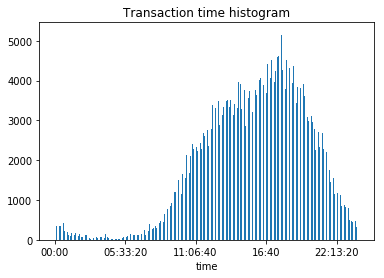

In [434]:
time, customers = np.unique(transaction_df.trans_time.sort_values(), return_counts=True)
plt.bar(time, customers, width=30)
plt.title("Transaction time histogram")
plt.show()

*comment:*
> The amount of transaction reach a first *local maximum* around noon and the global maximum around 5p.m. which is intuitive. Indeed, people go shopping either during lunch time or after work.

In [ ]:
# household vs days (bias ?)

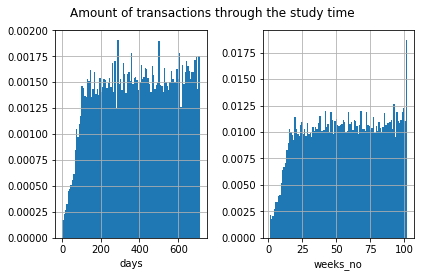

In [435]:
fig, axes = plt.subplots(1, 2)
transaction_df.day.hist(bins=100, ax=axes[0], density=True)
axes[0].set_xlabel("days")
transaction_df.week_no.hist(bins=100, ax=axes[1], density=True)
axes[1].set_xlabel("weeks_no")
plt.suptitle("Amount of transactions through the study time")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

*comment:*
1. We see an increasing phase of transactions during the first 100 days (15 weeks). This suggests that data collection was "on-flight" or that data sampling was not gathered properly.
2. Thus, we decide to build a new transaction dataframe where we cut the transactions before this date. We will us it for applications where it could potentially induce bias.
3. A whole section will deal bias later in the the process.

**Discount related**

In [446]:
transaction_df.describe()

,day,quantity,sales_value,store_id,retail_disc,week_no,coupon_disc,coupon_match_disc
count,2.595732e+06,2.595732e+06,2.595732e+06,2.595732e+06,2.595732e+06,2.595732e+06,2.595732e+06,2.595732e+06
mean,3.887562e+02,1.004286e+02,3.104120e+00,3.142673e+03,-5.387054e-01,5.622150e+01,-1.641600e-02,-2.918564e-03
std,1.897210e+02,1.153436e+03,4.182274e+00,8.937113e+03,1.249191e+00,2.710223e+01,2.168410e-01,3.969004e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-1.800000e+02,1.000000e+00,-5.593000e+01,-7.700000e+00
25%,2.290000e+02,1.000000e+00,1.290000e+00,3.300000e+02,-6.900000e-01,3.300000e+01,0.000000e+00,0.000000e+00
50%,3.900000e+02,1.000000e+00,2.000000e+00,3.720000e+02,-1.000000e-02,5.600000e+01,0.000000e+00,0.000000e+00
75%,5.530000e+02,1.000000e+00,3.490000e+00,4.220000e+02,0.000000e+00,8.000000e+01,0.000000e+00,0.000000e+00
max,7.110000e+02,8.963800e+04,8.400000e+02,3.428000e+04,3.990000e+00,1.020000e+02,0.000000e+00,0.000000e+00


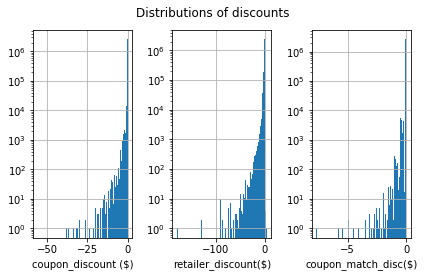

In [451]:
fig, axes = plt.subplots(1, 3)
plt.suptitle("Distributions of discounts")
transaction_df.coupon_disc.hist(bins=100, ax=axes[0])
axes[0].set_xlabel("coupon_discount ($)")
axes[0].set_yscale('log')
transaction_df.retail_disc.hist(bins=100, ax=axes[1])
axes[1].set_xlabel("retailer_discount($)")
axes[1].set_yscale('log')
transaction_df.coupon_match_disc.hist(bins=100, ax=axes[2])
axes[2].set_xlabel("coupon_match_disc($)")
axes[2].set_yscale('log')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

*comment:*
> We observe the dicount: it is sharply distributed close to 0.

**Quantities related**:

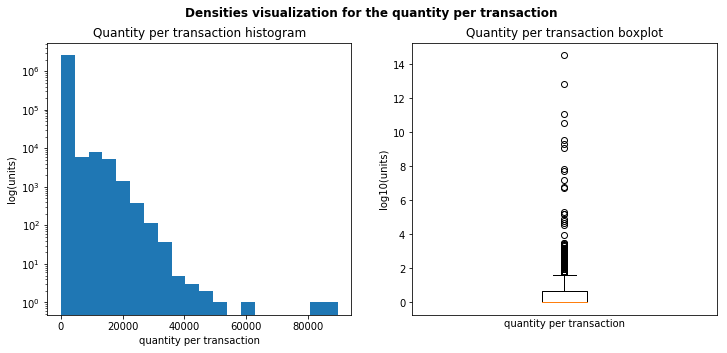

In [452]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("Densities visualization for the quantity per transaction", fontweight='bold')

axes[0].hist(transaction_df.quantity, log=True, bins=20)
axes[0].set_title("Quantity per transaction histogram")
axes[0].set_xlabel("quantity per transaction")
axes[0].set_ylabel("log(units)")

axes[1].boxplot(np.log(transaction_df.quantity.value_counts()))
axes[1].set_xticks([0])
axes[1].set_title("Quantity per transaction boxplot")
axes[1].set_ylabel("log10(units)")
axes[1].set_xlabel("quantity per transaction")

plt.show()

*comment:*
1. Both figures (histogram and boxplot) show that the largest part of quantities exchange per transaction is less than 20 units.
2. The median is really close to 1 (log10(units)) meaning that 50% of the quantity per transaction is less than 10.
3. The boxplot show us that there is a lot of outliers. We will investigate on that latter in the outliers part.

In [453]:
count, qty = np.histogram(transaction_df.quantity)


**Sales value related:**

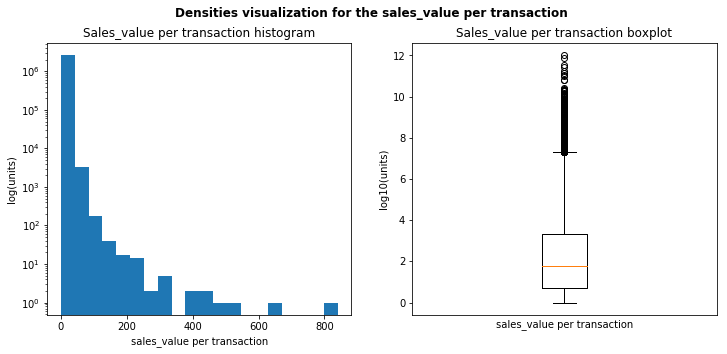

In [454]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("Densities visualization for the sales_value per transaction", fontweight='bold')

axes[0].hist(transaction_df.sales_value, log=True, bins=20)
axes[0].set_title("Sales_value per transaction histogram")
axes[0].set_xlabel("sales_value per transaction")
axes[0].set_ylabel("log(units)")

axes[1].boxplot(np.log(transaction_df.sales_value.value_counts()))
axes[1].set_xticks([0])
axes[1].set_title("Sales_value per transaction boxplot")
axes[1].set_ylabel("log10(units)")
axes[1].set_xlabel("sales_value per transaction")

plt.show()

*comment:*
1. The densities are similar as the quantity feature in the sense that they have similar shape with many outliers.
2. However the whiskers from sales_value are in wider range than quantity feature.
3. All that suggests that outliers from the quantity feature and those from sales_value are related. As stated previously, we will investigate on that later on.

**store id:**

In [455]:
unique_stores = np.unique(transaction_df.store_id.values)
print(f"Number of unique stores: {len(unique_stores)}")

Number of unique stores: 582


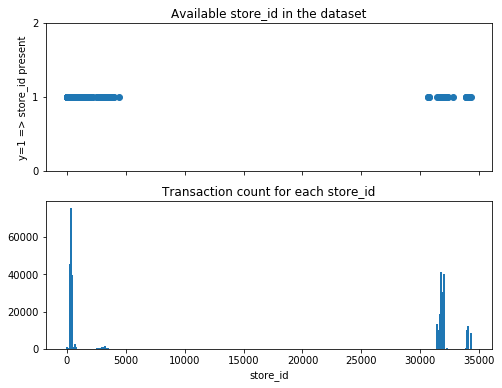

In [456]:
# here we want to evaluate what are the stores who have the higher amount of transactions
transaction_per_store = transaction_df.store_id.value_counts().sort_index()

fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
plt.suptitle("")
axes[0].scatter(unique_stores, [1 for i in range(len(unique_stores))])
axes[0].set_yticks(range(3))
axes[0].set_title("Available store_id in the dataset")
axes[0].set_ylabel("y=1 => store_id present")

axes[1].bar(transaction_per_store.index, transaction_per_store.values, width=150)
axes[1].set_title("Transaction count for each store_id")

plt.xlabel("store_id")
plt.show()

*comment:*
1. From fig1 we observe that there is two clusteres of stores id ([0, 5000], [30000, 35000]). If we assume that store_id are given from geographical position, we could say that this dataset is taken from two different regions.
2. In this two cluster some stores have a lot of transactions and some have much less. This could suggest two main explainations:
> * Either this is due to bad sampling routine. In this case we should be really attentive to any bias in the dataset.
> * Or it could be the fact of different size of shopping centers and then we should simply remove small shopping centers when the application asks for it.

<a id=d_demo></a>
#### Demographic

In [457]:
def print_cat_bar(df):
    df_cat = df.select_dtypes(include='category')
    fig = plt.figure(figsize=(10, 15))
    cols = df_cat.columns
    columns = 2
    rows = len(cols) / columns + 1

    for i in range(0, len(cols)):
        ax = fig.add_subplot(rows, columns, i+1)
        sns.countplot(data=df_cat, x=cols[i], ax=ax)
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            
    return fig

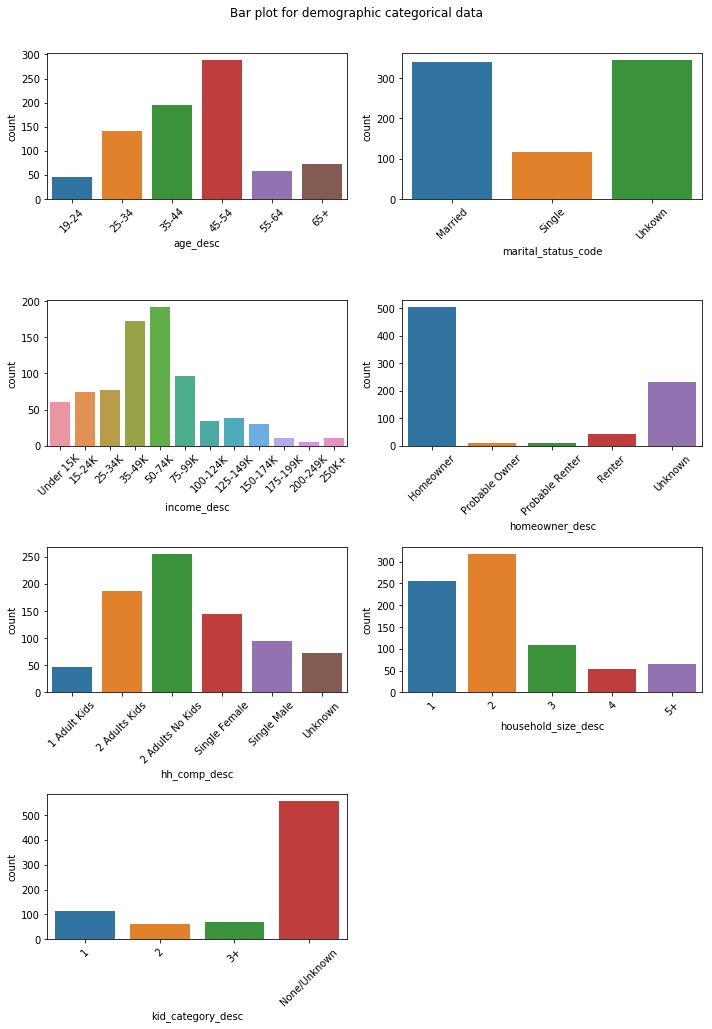

In [458]:
fig = print_cat_bar(demographic_df)
fig.axes[1].set_xticklabels(('Married', 'Single', 'Unkown'))
fig.suptitle("Bar plot for demographic categorical data")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

*Comment:*
1. As the figures above suggest it, the typical houshold in this dataset:
    * is between 25 and 54 years old
    * is married
    * has a median salary (between 35k and 74k per year)
    * is homeowner
    * is composed of 2 adults with few are no children
2. An ideal data sampling would have select more uniformly the data two draw conclusion on the general population. We could find some reason to this non uniform data sampling
    * This dataset is on marketing purpose. They wanted to target people in a wiser manner. Thus, it is likely they chose the most interesting people for them to increase their benefits **=> middle class households**
    * They recruit people on volontar basis and could not chose equilibrated household compositions.
   

<a id=d_prod></a>
#### Products

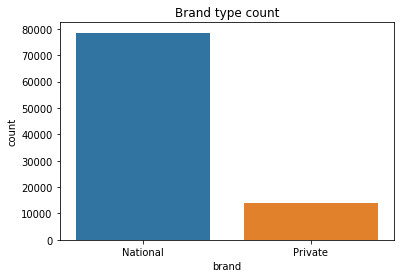

In [460]:
sns.countplot(x='brand', data=product_df)
plt.title("Brand type count")
plt.show()

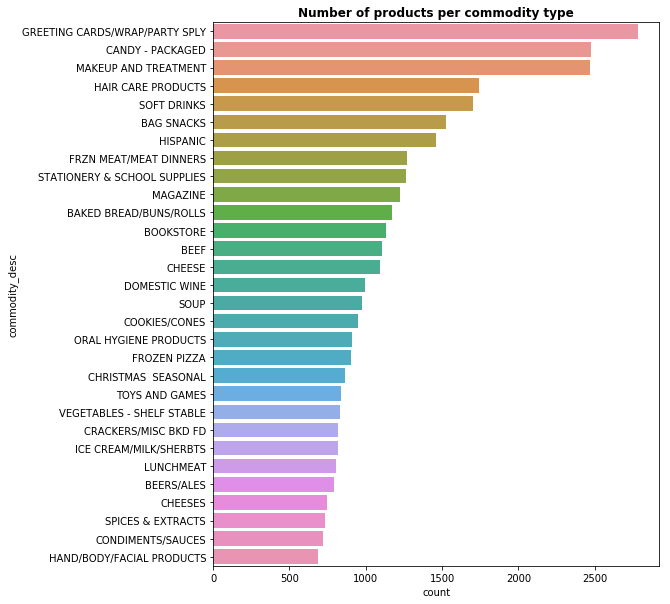

In [461]:
# Display the amount of available products per commodity type
plt.figure(figsize=(8, 10))
sns.countplot(y='commodity_desc', data=product_df, order=product_df['commodity_desc'].value_counts().iloc[:30].index)
plt.tick_params(axis='y')
plt.title("Number of products per commodity type", fontweight='bold')
plt.show()

<a id=outliers></a>
### Outliers analysis

**TODO**

### Dealing with bias

**TODO**

<a id=explo></a>
# 3. Exploitation

## A. Specific preprocessing

## B. Nutrient module

In [ ]:
'''Y. AND J. THIS IS FOR YOU GUYS'''

## C. Time series analysis

### C.1 Find out season with time anonymised data

### C.2 Find out high rate sold product throughout the day

### C.3 Trending products

## D. Influence of demographic factors on shopping habits.

## E. Top bought item per household

## F. Predict marital status and household composition

## G. Obesity detection